Exploring a dataset with information about patients. 
Consider next 8 features to predict the mortality rate:
1. Age
2. ОССН KiLLip
3. HBR (b)
4. Systolic AP(b)
5. Creatine in blood
6. EF Percentage
7. White blood cells count
8. Glucose

# 1. Import required libraries and load the dataset

In [3]:
import numpy as np
import pandas as pd
from IPython.display import display

In [4]:
# Load dataset
ready_data = pd.read_csv('./import/dataset_prepared.csv')

# 2. Split the dataset into features and target.

In [5]:
X = ready_data.drop('Class', axis=1)
y = ready_data['Class']

We want to consider hyper parameters, so we will use three different random_state parameters. 

In [6]:
random_states = [0, 25, 42]

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import shap

In [22]:
feature_names = ["Age", "CHF KiLLip", "HBR (b)", "Systolic AP(b)", "Creatinine in blood", "EF Percentage", "White blood cells count", "Glucose"]

feature_importances = pd.DataFrame(index=feature_names)
shap_values_list = []

# Standardizing, because sklearn.linear_model.LogisticRegression uses L2-penalty by default, which is Ridge Regression.
# https://hastie.su.domains/Papers/ESLII.pdf 
# page 82: 
# "The ridge solutions are not equivariant under scaling of the inputs, and so one normally standardizes the inputs before solving."

for random_state in random_states:

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = LogisticRegression(random_state=random_state, class_weight="balanced")

   # Some solvers only support certain types of penalties, so we must specify compatible combinations
    hyperparameter_grid = [
        # For 'l1' penalty, 'liblinear' and 'saga' solvers can be used
        {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
        # For 'l2' penalty, all solvers can be used
        {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
        # For 'elasticnet' penalty, only 'saga' solver can be used. Also, l1_ratio parameter is needed for 'elasticnet' penalty
        {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'l1_ratio': [0, 0.5, 1]}
    ]

    # define the grid search
    grid_cv = GridSearchCV(estimator=model, 
                           param_grid=hyperparameter_grid,
                           cv=skf,
                           scoring='f1_macro')
    
    # execute the grid search
    grid_cv.fit(X_train, y_train)
    
    display(grid_cv.best_params_)
    
    # retrain the model with the best parameters found
    model = LogisticRegression(random_state=random_state, 
                               C=grid_cv.best_params_['C'], 
                               penalty=grid_cv.best_params_['penalty'], 
                               solver=grid_cv.best_params_['solver'],
                               class_weight="balanced")

    model.fit(X_train, y_train)

    # prediction probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # AUC-ROC score
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    print(f'AUC-ROC score for {random_state=}: {auc_roc}')

    # prediction class
    y_pred = model.predict(X_test)

    # Other scores
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion matrix for {random_state=}: \n{cm}')
    
    # SHAP values
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    shap_values_list.append(shap_values.values)
    feature_importances[random_state] = model.coef_.ravel()
    feature_importances[str(random_state)+"_shap"] = np.mean(np.abs(shap_values.values), axis=0)


feature_importances['mean_coef'] = feature_importances[[state for state in random_states]].mean(axis=1)
feature_importances['mean_shap'] = feature_importances[[str(state) + "_shap" for state in random_states]].mean(axis=1)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


{'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}

AUC-ROC score for random_state=0: 0.9116112198303978
              precision    recall  f1-score   support

           0       0.99      0.85      0.92       584
           1       0.16      0.81      0.27        21

    accuracy                           0.85       605
   macro avg       0.58      0.83      0.59       605
weighted avg       0.96      0.85      0.89       605

Confusion matrix for random_state=0: 
[[496  88]
 [  4  17]]


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


{'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}

AUC-ROC score for random_state=25: 0.8819308545335942
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       584
           1       0.16      0.76      0.27        21

    accuracy                           0.86       605
   macro avg       0.58      0.81      0.59       605
weighted avg       0.96      0.86      0.90       605

Confusion matrix for random_state=25: 
[[502  82]
 [  5  16]]


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

{'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}

AUC-ROC score for random_state=42: 0.9350945857795172
              precision    recall  f1-score   support

           0       1.00      0.83      0.91       584
           1       0.17      0.95      0.29        21

    accuracy                           0.84       605
   macro avg       0.58      0.89      0.60       605
weighted avg       0.97      0.84      0.89       605

Confusion matrix for random_state=42: 
[[486  98]
 [  1  20]]


In [24]:
feature_importances

,0,0_shap,25,25_shap,42,42_shap,mean_coef,mean_shap
Age,0.114243,0.089869,0.127402,0.103967,0.134023,0.106637,0.125223,0.100158
CHF KiLLip,0.207196,0.178395,0.213957,0.175723,0.199145,0.170888,0.206766,0.175002
HBR (b),0.215764,0.170328,0.230904,0.155431,0.214671,0.168650,0.220446,0.164803
Systolic AP(b),-0.125428,0.097366,-0.073565,0.056649,-0.086808,0.064237,-0.095267,0.072751
Creatinine in blood,0.167493,0.097678,0.168379,0.100986,0.171346,0.100680,0.169073,0.099782
EF Percentage,-0.315112,0.254006,-0.316367,0.257168,-0.295081,0.229318,-0.308853,0.246831
White blood cells count,0.134403,0.106509,0.140551,0.113394,0.179244,0.143935,0.151400,0.121279
Glucose,0.165555,0.079799,0.188621,0.094259,0.156158,0.127223,0.170111,0.100427


In [25]:
import matplotlib.pyplot as plt

def plot_weights (feature_importances, column1, column2, label1, label2, title, num_digits=3):
    barWidth = 0.25

    r1 = np.arange(len(feature_importances[column1]))
    r2 = [x + barWidth for x in r1]

    plt.figure(figsize=(13, 6))
    bars1 = plt.barh(r1, feature_importances[column1], color='blue', height=barWidth, edgecolor='grey', label=label1)
    bars2 = plt.barh(r2, feature_importances[column2], color='orange', height=barWidth, edgecolor='grey', label=label2)

    plt.yticks([r + barWidth for r in range(len(feature_importances[column1]))], feature_importances.index)

    def add_values(bars):
        for bar in bars:
            width = bar.get_width()
            plt.text(width,               
                    bar.get_y() + bar.get_height() / 2.2 ,  
                    f"{width :.{num_digits}f}",  
                    ha='left', va='center')  


    add_values(bars1)
    add_values(bars2)

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()

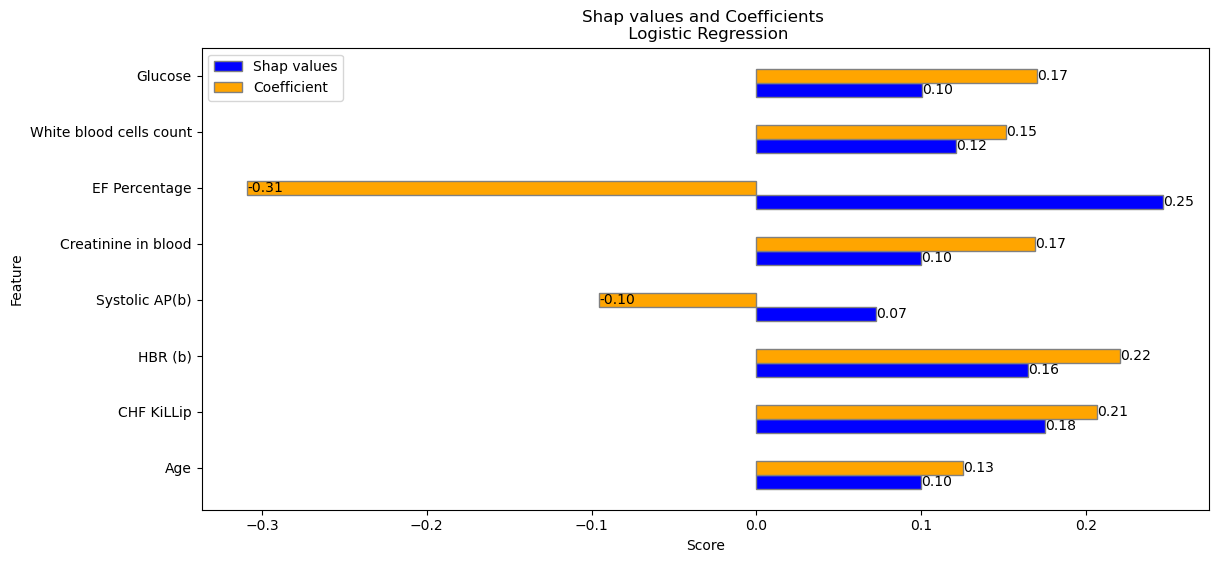

In [26]:
plot_weights(feature_importances, 
             column1='mean_shap', 
             column2='mean_coef', 
             label1='Shap values', 
             label2='Coefficient', 
             title='Shap values and Coefficients \n Logistic Regression',
             num_digits=2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


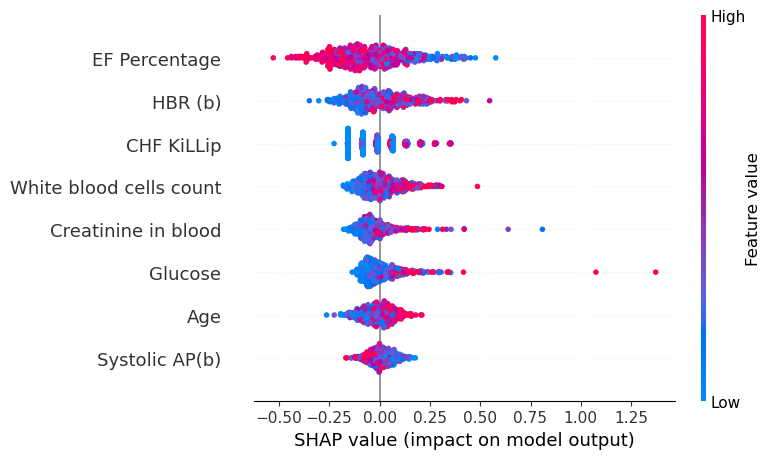

In [27]:
mean_shap_values = np.mean(shap_values_list, axis=0)
shap.summary_plot(mean_shap_values, X_test, feature_names=feature_names)